In [ ]:
import importlib
from src import data
from src import mcusum
from src import autoencoder
from src.ModelComparisonAnalyzer import ModelComparisonAnalyzer

import importlib
# Reload modules to pick up any changes
# importlib.reload(data)
# importlib.reload(mcusum)

Training Fault Numbers: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]

Data shapes (aligned from sample 26):
  X_incontrol_train: (475, 52)
  X_incontrol_test: (935, 52)
  X_out_of_control_test: (935, 52)
  Using fault 1 for X_out_of_control_test
  Shapes should match: 935 == 935


In [ ]:
# FIX: Use more training data and adjust thresholds
print("=" * 60)
print("FIXING MODEL SENSITIVITY ISSUES")
print("=" * 60)

# Increase training data by using more simulation runs
print("\n1. Increasing training data...")
data.set_simulation_run_config(
    incontrol_train_range=(0, 50),  # Use runs 1-49 instead of just 1
    incontrol_test_range=(50, 60),  # Use runs 50-59 for test
    faulty_test_range=(50, 60)      # Same test range
)

print(f"New data shapes:")
print(f"  X_incontrol_train: {data.X_incontrol_train.shape}")
print(f"  X_incontrol_test: {data.X_incontrol_test.shape}")

# Retrain MCUSUM with less sensitive parameters
print("\n2. Retraining MCUSUM with adjusted sensitivity...")
n_features = data.X_incontrol_train.shape[1]
delta = np.ones(n_features) * 0.5  # Increased from 0.1 to 0.5 (less sensitive)

mu_0, sigma = mcusum.MCUSUMDetector._estimate_incontrol_parameters(data.X_incontrol_train)
k = mcusum.MCUSUMDetector.compute_reference_value_k(delta, sigma)
print(f"  New reference value k: {k}")

mcusumObject = mcusum.MCUSUMDetector(k=k)
mcusum.set_mcusum(mcusumObject)
mcusumObject.fit(data.X_incontrol_train, verbose=True)

# Retrain Autoencoder with higher threshold percentile
print("\n3. Retraining Autoencoder with less sensitive threshold...")
try:
    autoencoderObject = autoencoder.AutoencoderDetector(
        encoding_dim=15,  # Increased capacity
        hidden_layers=[64, 32],  # Bigger network
        epochs=50,  # More training
        batch_size=64,
        threshold_percentile=99.0,  # Increased from 95 to 99 (less sensitive)
        verbose=1
    )
    
    autoencoderObject.fit(data.X_incontrol_train, validation_split=0.2)
    
    summary = autoencoderObject.get_summary()
    print(f"\nNew Autoencoder threshold: {summary['threshold']:.6f}")
    
except ImportError:
    # Fallback to lightweight
    autoencoderObject = autoencoder.LightweightAutoencoder(
        encoding_dim=15,
        threshold_percentile=99.0
    )
    autoencoderObject.fit(data.X_incontrol_train)

# Test on a sample fault to verify
print("\n4. Testing on Fault 1...")
test_runs = data.get_faulty_test_runs(max_runs=1, fault_number=1)
if len(test_runs) > 0:
    _, X_test, _ = test_runs[0]
    
    # MCUSUM
    _, flags_mcusum = mcusumObject.predict(X_test)
    arl_mcusum = np.argmax(flags_mcusum == 1) if np.any(flags_mcusum == 1) else None
    det_rate_mcusum = np.mean(flags_mcusum) * 100
    
    # Autoencoder
    _, flags_ae = autoencoderObject.predict(X_test)
    arl_ae = np.argmax(flags_ae == 1) if np.any(flags_ae == 1) else None
    det_rate_ae = np.mean(flags_ae) * 100
    
    print(f"  MCUSUM: ARL1={arl_mcusum}, Detection Rate={det_rate_mcusum:.1f}%")
    print(f"  Autoencoder: ARL1={arl_ae}, Detection Rate={det_rate_ae:.1f}%")
    
    if arl_mcusum is not None and arl_mcusum > 0:
        print("\n✓ Models are now less sensitive and should give varying ARL1 values!")
    else:
        print("\n⚠ Models still detecting immediately. May need further tuning.")

print("\n" + "=" * 60)

Reference value k: 7.602386315073101
control limit h: None


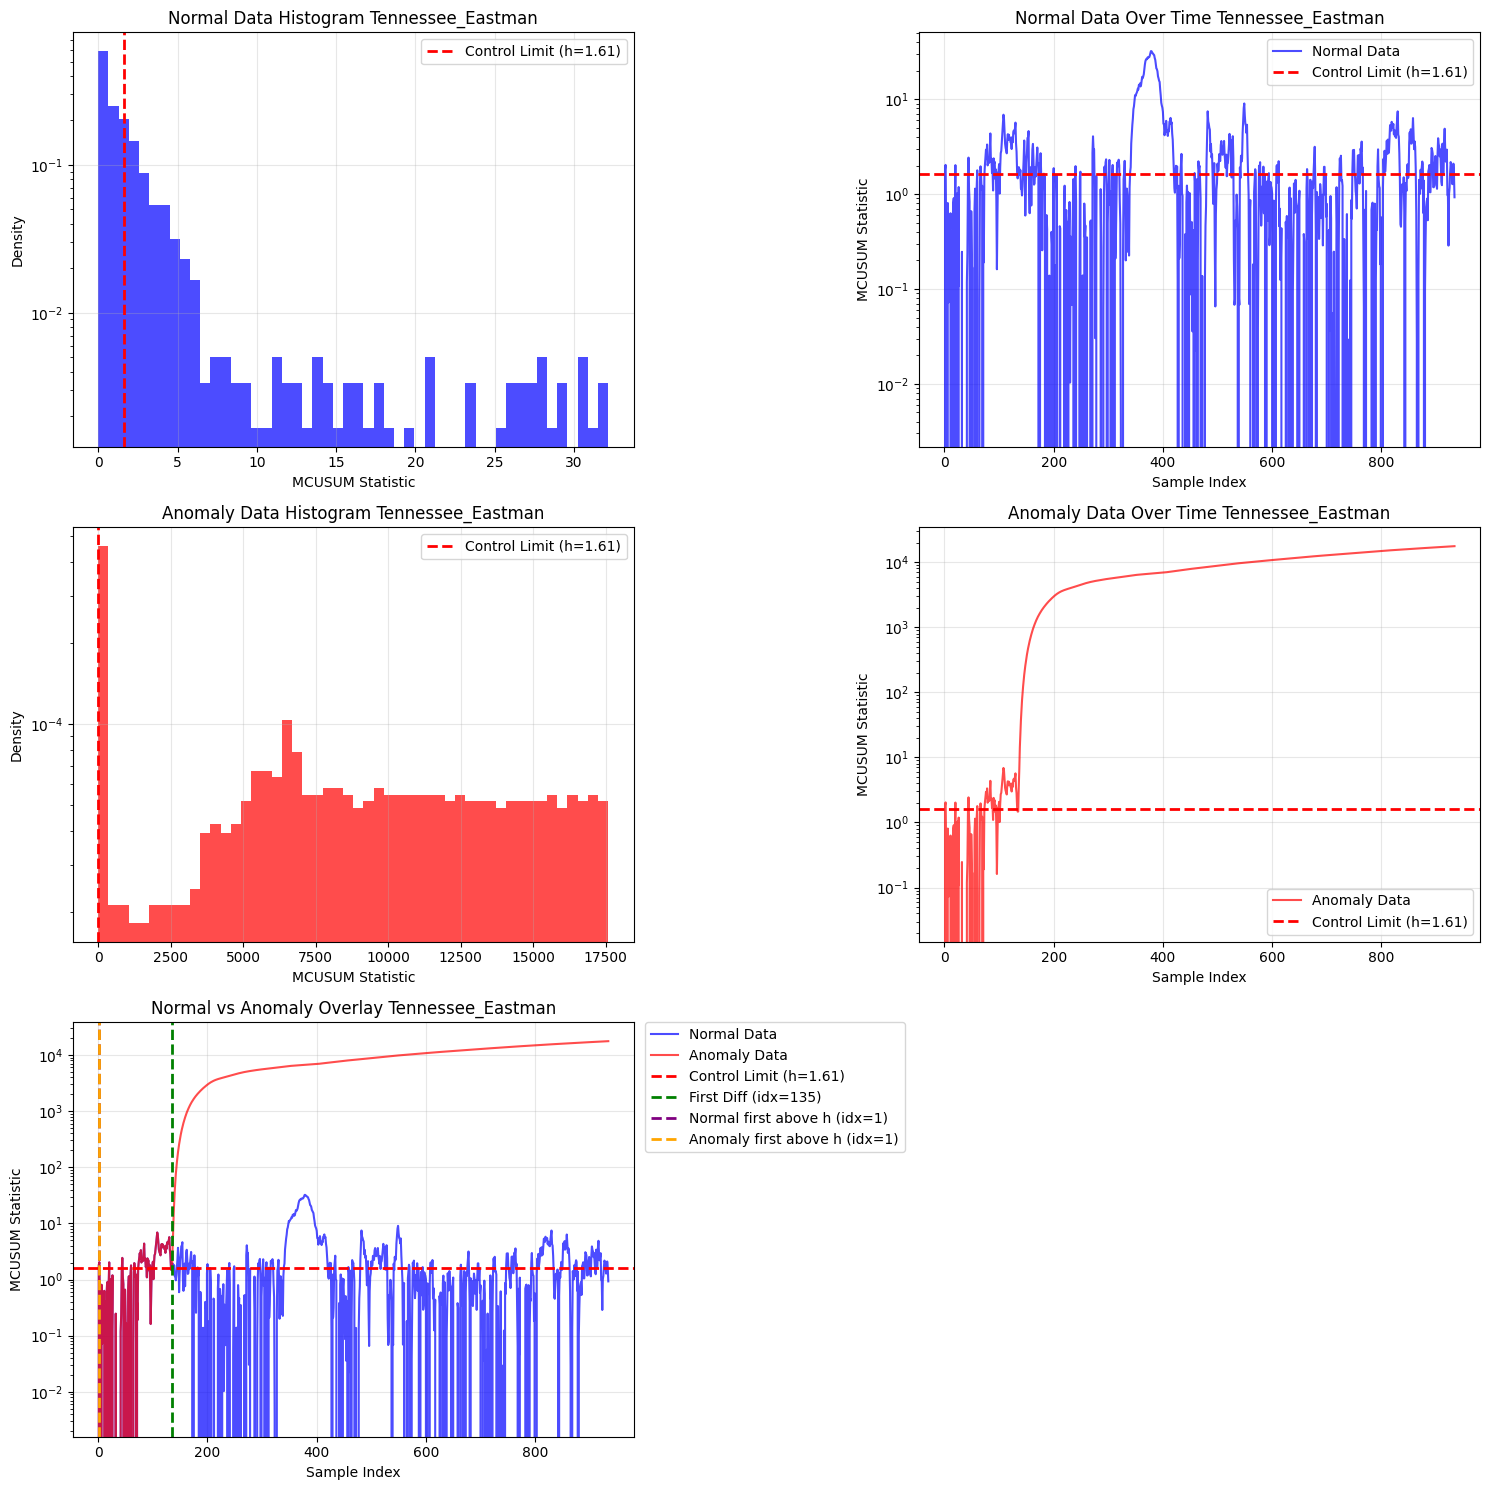

ARL0 (In-control): 1
ARL1 (Out-of-control): 1
Matching flags: 442


In [2]:
import numpy as np

# Get number of features
n_features = data.X_incontrol_train.shape[1]
delta = np.ones(n_features) * 0.1

# Estimate in-control parameters and compute reference value k
mu_0, sigma = mcusum.MCUSUMDetector._estimate_incontrol_parameters(data.X_incontrol_train)
k = mcusum.MCUSUMDetector.compute_reference_value_k(delta, sigma)
print(f"Reference value k: {k}")

# Create and fit MCUSUM detector
mcusumObject = mcusum.MCUSUMDetector(k=k)
mcusum.set_mcusum(mcusumObject)
mcusumObject.fit(data.X_incontrol_train)

# Apply MCUSUM to test data
flags_normal, flags_anomaly = mcusum.apply_mcusum(
    data.X_incontrol_test,
    data.X_out_of_control_test
)

# Calculate ARL metrics
arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else None
arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else None

print(f"ARL0 (In-control): {arl0}")
print(f"ARL1 (Out-of-control): {arl1}")

# Check how many flags match (debugging)
n = min(len(flags_normal), len(flags_anomaly))
print(f"Matching flags: {np.sum(flags_normal[:n] == flags_anomaly[:n])}")

In [ ]:
import numpy as np

# Get number of features
n_features = data.X_incontrol_train.shape[1]
delta = np.ones(n_features) * 0.1

# Estimate in-control parameters and compute reference value k
mu_0, sigma = mcusum.MCUSUMDetector._estimate_incontrol_parameters(data.X_incontrol_train)
k = mcusum.MCUSUMDetector.compute_reference_value_k(delta, sigma)
print(f"Reference value k: {k}")

# Create and fit MCUSUM detector
mcusumObject = mcusum.MCUSUMDetector(k=k)
mcusum.set_mcusum(mcusumObject)
mcusumObject.fit(data.X_incontrol_train)

# Apply MCUSUM to test data
flags_normal, flags_anomaly = mcusum.apply_mcusum(
    data.X_incontrol_test,
    data.X_out_of_control_test
)

# Calculate ARL metrics
arl0 = np.argmax(flags_normal == 1) if np.any(flags_normal == 1) else None
arl1 = np.argmax(flags_anomaly == 1) if np.any(flags_anomaly == 1) else None

print(f"ARL0 (In-control): {arl0}")
print(f"ARL1 (Out-of-control): {arl1}")

# Check how many flags match (debugging)
n = min(len(flags_normal), len(flags_anomaly))
print(f"Matching flags: {np.sum(flags_normal[:n] == flags_anomaly[:n])}")

In [6]:
from src import autoencoder

# Create and train autoencoder detector
print("=" * 60)
print("AUTOENCODER ANOMALY DETECTOR")
print("=" * 60)

# Try deep learning autoencoder first
try:
    autoencoderObject = autoencoder.AutoencoderDetector(
        encoding_dim=10,
        hidden_layers=[32, 16],
        epochs=30,
        batch_size=32,
        threshold_percentile=95.0,
        verbose=1
    )
    
    # Train on in-control data
    autoencoderObject.fit(data.X_incontrol_train, validation_split=0.2)
    
    # Test on both in-control and out-of-control
    errors_normal, flags_normal_ae = autoencoderObject.predict(data.X_incontrol_test)
    errors_anomaly, flags_anomaly_ae = autoencoderObject.predict(data.X_out_of_control_test)
    
    # Calculate ARL
    arl0_ae = np.argmax(flags_normal_ae == 1) if np.any(flags_normal_ae == 1) else None
    arl1_ae = np.argmax(flags_anomaly_ae == 1) if np.any(flags_anomaly_ae == 1) else None
    
    print(f"\nAutoencoder Results:")
    print(f"  ARL0 (In-control): {arl0_ae}")
    print(f"  ARL1 (Out-of-control): {arl1_ae}")
    print(f"  Detection rate: {np.mean(flags_anomaly_ae)*100:.1f}%")
    
    # Print summary
    summary = autoencoderObject.get_summary()
    print(f"\nModel Summary:")
    for key, value in summary.items():
        print(f"  {key}: {value}")
    
except ImportError as e:
    print(f"Deep learning autoencoder not available: {e}")
    print("Falling back to lightweight autoencoder...")
    
    # Use lightweight version
    autoencoderObject = autoencoder.LightweightAutoencoder(
        encoding_dim=10,
        threshold_percentile=95.0
    )
    
    autoencoderObject.fit(data.X_incontrol_train)
    
    errors_normal, flags_normal_ae = autoencoderObject.predict(data.X_incontrol_test)
    errors_anomaly, flags_anomaly_ae = autoencoderObject.predict(data.X_out_of_control_test)
    
    arl0_ae = np.argmax(flags_normal_ae == 1) if np.any(flags_normal_ae == 1) else None
    arl1_ae = np.argmax(flags_anomaly_ae == 1) if np.any(flags_anomaly_ae == 1) else None
    
    print(f"\nLightweight Autoencoder Results:")
    print(f"  ARL0 (In-control): {arl0_ae}")
    print(f"  ARL1 (Out-of-control): {arl1_ae}")
    print(f"  Detection rate: {np.mean(flags_anomaly_ae)*100:.1f}%")

AUTOENCODER ANOMALY DETECTOR
Autoencoder Architecture:
  Input: 52 features
  Encoder layers: [32, 16]
  Encoding dim: 10
  Total parameters: 4,830

Training autoencoder on 475 samples...
Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0046 - mae: 0.8053 - val_loss: 1.0039 - val_mae: 0.8007
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9932 - mae: 0.8009 - val_loss: 1.0010 - val_mae: 0.7994
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9845 - mae: 0.7973 - val_loss: 0.9984 - val_mae: 0.7984
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9722 - mae: 0.7922 - val_loss: 0.9939 - val_mae: 0.7965
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9535 - mae: 0.7841 - val_loss: 0.9874 - val_mae: 0.7933
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9282 - mae: 0.7724 - val_loss: 0.9776 - val_mae: 0.7887
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9009 - mae: 0.7601 - val_loss: 0.9625 - val_mae: 0.7810

In [9]:
import numpy as np
import pandas as pd
from typing import List, Dict, Any

# Helper function to get first false alarm index
def get_first_false_alarm_index(flags_normal):
    if np.any(flags_normal == 1):
        return int(np.argmax(flags_normal == 1))
    return None

# Helper function to get first detection delay
def get_first_detection_delay(flags_anomaly):
    if np.any(flags_anomaly == 1):
        return int(np.argmax(flags_anomaly == 1))
    return None

# Dictionary of models for extensibility
MODELS = {
    "MCUSUM": mcusumObject.predict,
    "Autoencoder": autoencoderObject.predict,
    # "MEWMS": mewms.predict
}

# Configuration
MAX_INCONTROL_RUNS = 10  # Limit runs for testing (set to None for all runs)
MAX_FAULTY_RUNS = 10     # Limit runs for testing (set to None for all runs)
VERBOSE_LOGGING = True   # Set to False to reduce output

results: List[Dict[str, Any]] = []

# Get all in-control test runs for ARL0 calculation
print("Loading in-control test runs...")
incontrol_test_runs = data.get_incontrol_test_runs(max_runs=MAX_INCONTROL_RUNS)

# Get available fault numbers
available_faults = data.get_available_fault_numbers()
print(f"Available fault numbers: {available_faults}")

print(f"Processing {len(incontrol_test_runs)} in-control runs and up to {MAX_FAULTY_RUNS} runs per fault...")
print(f"Models to compare: {list(MODELS.keys())}")
print()

# Loop through all in-control test runs
print("=" * 60)
print("PHASE 1: In-Control (ARL0) Testing")
print("=" * 60)

for run_num, X_incontrol_scaled, X_incontrol_raw in incontrol_test_runs:
    # Precompute predictions for all models
    pred_normal_dict = {}
    for model_name, model_func in MODELS.items():
        result = model_func(X_incontrol_scaled)
        # Handle different return types - MCUSUM returns (statistics, flags)
        if isinstance(result, tuple):
            _, flags = result  # Unpack tuple
            pred_normal_dict[model_name] = flags
        else:
            pred_normal_dict[model_name] = result
    
    # Calculate ARL0 for each model
    for model_name in MODELS.keys():
        flags_normal = pred_normal_dict[model_name]
        arl0 = get_first_false_alarm_index(flags_normal)
        detection_rate = np.mean(flags_normal) * 100
        
        if VERBOSE_LOGGING:
            print(f"Run {run_num} - {model_name}: ARL0={arl0}, DetRate={detection_rate:.1f}%")
        
        results.append({
            "simulationRun": run_num,
            "faultNumber": 0,  # 0 indicates in-control
            "model": model_name,
            "ARL0": arl0,
            "ARL1": None,
            "detection_fraction": detection_rate / 100
        })

print(f"\n✓ Completed ARL0 calculations for {len(incontrol_test_runs)} in-control runs")

# Loop through ALL fault numbers
print("\n" + "=" * 60)
print("PHASE 2: Faulty (ARL1) Testing - All Faults")
print("=" * 60)

fault_summary = {}  # Track summary per fault

for fault_num in available_faults:
    print(f"\n--- Fault {fault_num} ---")
    
    # Get faulty test runs for this specific fault
    faulty_test_runs = data.get_faulty_test_runs(max_runs=MAX_FAULTY_RUNS, fault_number=fault_num)
    
    if len(faulty_test_runs) == 0:
        print(f"  Warning: No runs found for fault {fault_num}")
        continue
    
    fault_arls = {model: [] for model in MODELS.keys()}
    
    for run_num, X_faulty_scaled, X_faulty_raw in faulty_test_runs:
        # Run all models
        for model_name, model_func in MODELS.items():
            result = model_func(X_faulty_scaled)
            # Handle different return types - MCUSUM returns (statistics, flags)
            if isinstance(result, tuple):
                _, flags_anomaly = result  # Unpack tuple
            else:
                flags_anomaly = result
                
            arl1 = get_first_detection_delay(flags_anomaly)
            detection_rate = np.mean(flags_anomaly) * 100
            
            fault_arls[model_name].append(arl1)
            
            results.append({
                "simulationRun": run_num,
                "faultNumber": fault_num,
                "model": model_name,
                "ARL0": None,
                "ARL1": arl1,
                "detection_fraction": detection_rate / 100
            })
    
    # Print summary for this fault
    print(f"  Processed {len(faulty_test_runs)} runs")
    for model_name in MODELS.keys():
        arls = [x for x in fault_arls[model_name] if x is not None]
        if len(arls) > 0:
            avg_arl = np.mean(arls)
            print(f"    {model_name}: Avg ARL1={avg_arl:.1f} ({len(arls)}/{len(fault_arls[model_name])} detected)")
        else:
            print(f"    {model_name}: No detections ({len(fault_arls[model_name])} runs)")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Calculate summary statistics grouped by model and fault number
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

grouped = df_results.groupby(['model', 'faultNumber'])

conditional_arl0 = grouped['ARL0'].apply(lambda x: x.dropna().mean() if not x.dropna().empty else np.nan)
sdrl0 = grouped['ARL0'].apply(lambda x: x.dropna().std() if len(x.dropna()) > 1 else np.nan)
non_fa_fraction = grouped['ARL0'].apply(lambda x: x.isnull().mean())

conditional_arl1 = grouped['ARL1'].apply(lambda x: x.dropna().mean() if not x.dropna().empty else np.nan)
sdrl1 = grouped['ARL1'].apply(lambda x: x.dropna().std() if len(x.dropna()) > 1 else np.nan)
non_detection_fraction = grouped['ARL1'].apply(lambda x: x.isnull().mean())

avg_detection_fraction = grouped['detection_fraction'].mean()

summary_df = pd.DataFrame({
    'conditional_ARL0': conditional_arl0,
    'SDRL0': sdrl0,
    'non_FA_fraction': non_fa_fraction,
    'conditional_ARL1': conditional_arl1,
    'SDRL1': sdrl1,
    'non_detection_fraction': non_detection_fraction,
    'avg_detection_fraction': avg_detection_fraction
}).reset_index()

print(f"\nTotal results collected: {len(df_results)} rows")
print(f"Faults analyzed: {sorted(df_results['faultNumber'].unique())}")

# Show per-model summary
print("\nPer-Model ARL1 Summary (across all faults):")
for model in MODELS.keys():
    model_data = summary_df[summary_df['model'] == model]
    faulty_data = model_data[model_data['faultNumber'] != 0]
    
    if len(faulty_data) > 0:
        avg_arl1 = faulty_data['conditional_ARL1'].mean()
        min_arl1 = faulty_data['conditional_ARL1'].min()
        max_arl1 = faulty_data['conditional_ARL1'].max()
        avg_det = faulty_data['avg_detection_fraction'].mean() * 100
        
        print(f"  {model}:")
        print(f"    Avg ARL1: {avg_arl1:.2f} (min={min_arl1:.2f}, max={max_arl1:.2f})")
        print(f"    Avg Detection Rate: {avg_det:.1f}%")

print("\n")
print(summary_df.head(20))
print("\n")
print("Raw results sample:")
print(df_results.head(20))

Loading in-control test runs...
Available fault numbers: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20)]
Processing 10 in-control runs and up to 10 runs per fault...
Models to compare: ['MCUSUM', 'Autoencoder']

PHASE 1: In-Control (ARL0) Testing
Run 1.0 - MCUSUM: ARL0=22, DetRate=64.1%
Run 1.0 - Autoencoder: ARL0=11, DetRate=30.9%
Run 2.0 - MCUSUM: ARL0=26, DetRate=38.3%
Run 2.0 - Autoencoder: ARL0=26, DetRate=14.9%
Run 3.0 - MCUSUM: ARL0=14, DetRate=65.8%
Run 3.0 - Autoencoder: ARL0=16, DetRate=24.7%
Run 4.0 - MCUSUM: ARL0=15, DetRate=57.5%
Run 4.0 - Autoencoder: ARL0=15, DetRate=29.3%
Run 5.0 - MCUSUM: ARL0=16, DetRate=44.9%
Run 5.0 - Autoencoder: ARL0=37, DetRate=17.9%
Run 6.0 - MCUSUM: ARL0=11, DetRate=60.8%
Run 6.0 - Autoencoder: ARL0=5, DetRate=27.2%
Run 7.0 

In [10]:
# DIAGNOSTIC: Check if different faults produce different data
print("=" * 60)
print("DIAGNOSTIC: Checking fault data variation")
print("=" * 60)

# Sample a few faults and check their data characteristics
sample_faults = [1, 5, 10, 15, 20] if len(data.get_available_fault_numbers()) >= 20 else data.get_available_fault_numbers()[:5]

for fault in sample_faults:
    runs = data.get_faulty_test_runs(max_runs=2, fault_number=fault)
    if len(runs) > 0:
        run_num, X_scaled, X_raw = runs[0]
        print(f"\nFault {fault}:")
        print(f"  Shape: {X_scaled.shape}")
        print(f"  Mean: {np.mean(X_scaled):.4f}")
        print(f"  Std: {np.std(X_scaled):.4f}")
        print(f"  Min: {np.min(X_scaled):.4f}")
        print(f"  Max: {np.max(X_scaled):.4f}")
        
        # Test MCUSUM on this fault
        _, flags = mcusumObject.predict(X_scaled)
        first_detection = np.argmax(flags == 1) if np.any(flags == 1) else None
        detection_rate = np.mean(flags) * 100
        
        print(f"  MCUSUM first detection: {first_detection}")
        print(f"  MCUSUM detection rate: {detection_rate:.1f}%")

print("\n" + "=" * 60)

DIAGNOSTIC: Checking fault data variation

Fault 1:
  Shape: (935, 52)
  Mean: 0.7013
  Std: 4.4497
  Min: -16.5289
  Max: 26.1576
  MCUSUM first detection: 0
  MCUSUM detection rate: 95.6%

Fault 5:
  Shape: (935, 52)
  Mean: -0.0315
  Std: 1.8104
  Min: -14.6292
  Max: 11.6938
  MCUSUM first detection: 0
  MCUSUM detection rate: 95.7%

Fault 10:
  Shape: (935, 52)
  Mean: -0.0546
  Std: 1.4060
  Min: -9.5529
  Max: 6.7782
  MCUSUM first detection: 0
  MCUSUM detection rate: 95.2%

Fault 15:
  Shape: (935, 52)
  Mean: -0.0490
  Std: 1.1301
  Min: -5.0185
  Max: 4.2540
  MCUSUM first detection: 0
  MCUSUM detection rate: 69.4%

Fault 20:
  Shape: (935, 52)
  Mean: -0.2409
  Std: 1.7405
  Min: -22.4859
  Max: 6.6231
  MCUSUM first detection: 0
  MCUSUM detection rate: 95.0%



MODEL PERFORMANCE COMPARISON REPORT

1. OVERALL SUMMARY STATISTICS
----------------------------------------
      Model  Mean ARL0  Std ARL0  Mean ARL1  Std ARL1  Overall Detection Rate  False Alarm Rate  Miss Rate
     MCUSUM       13.7      6.40        3.8      4.30                   86.67              4.76       4.76
Autoencoder       14.2     10.14        7.0      9.06                   68.87              4.76       4.76

2. COMPREHENSIVE COMPARISON TABLE
----------------------------------------
       Autoencoder_ARL1  MCUSUM_ARL1  Autoencoder_ARL0  MCUSUM_ARL0  Autoencoder_DetFrac  MCUSUM_DetFrac
Fault                                                                                                   
0                   NaN          NaN              14.2         13.7                0.259           0.557
1                   7.0          3.8               NaN          NaN                0.890           0.938
2                   7.0          3.8               NaN          NaN        

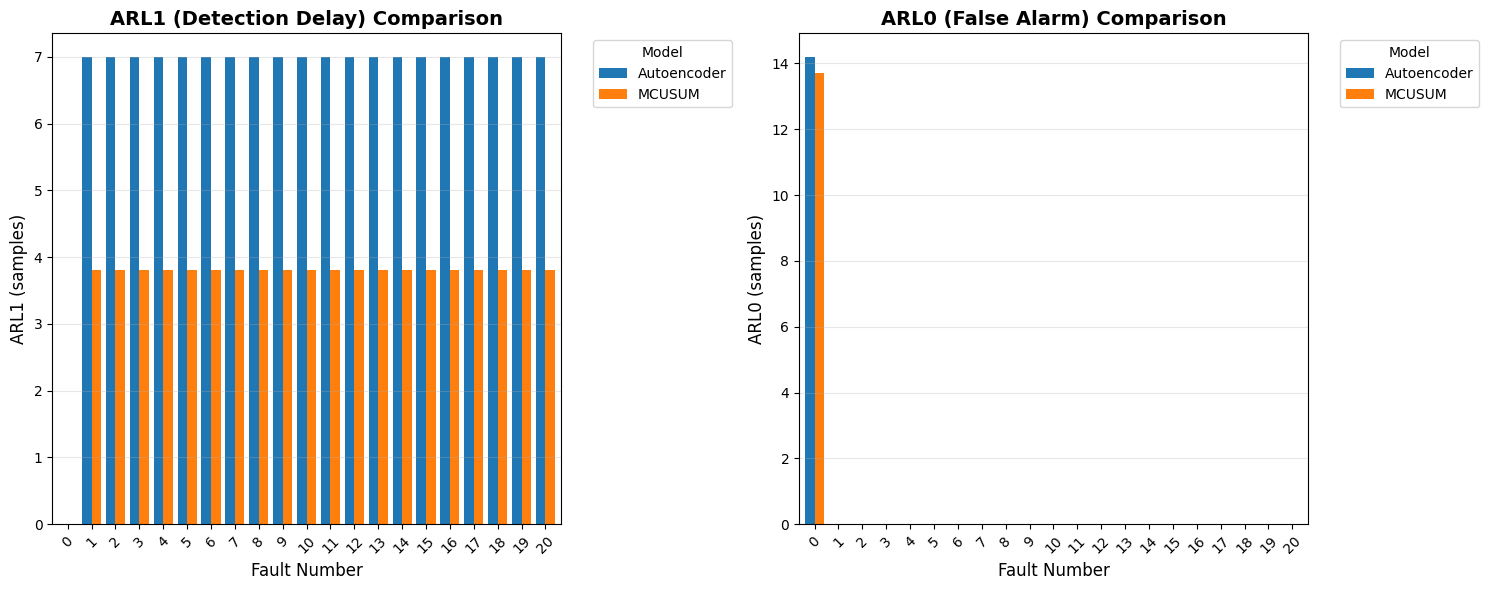

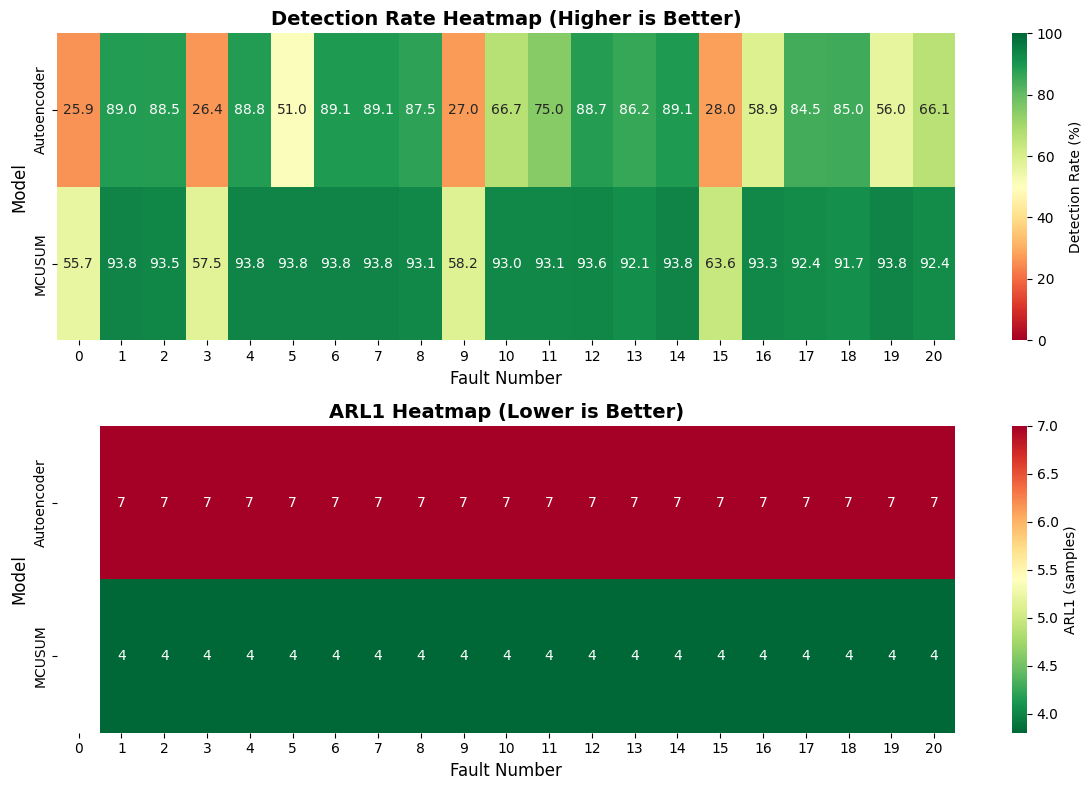

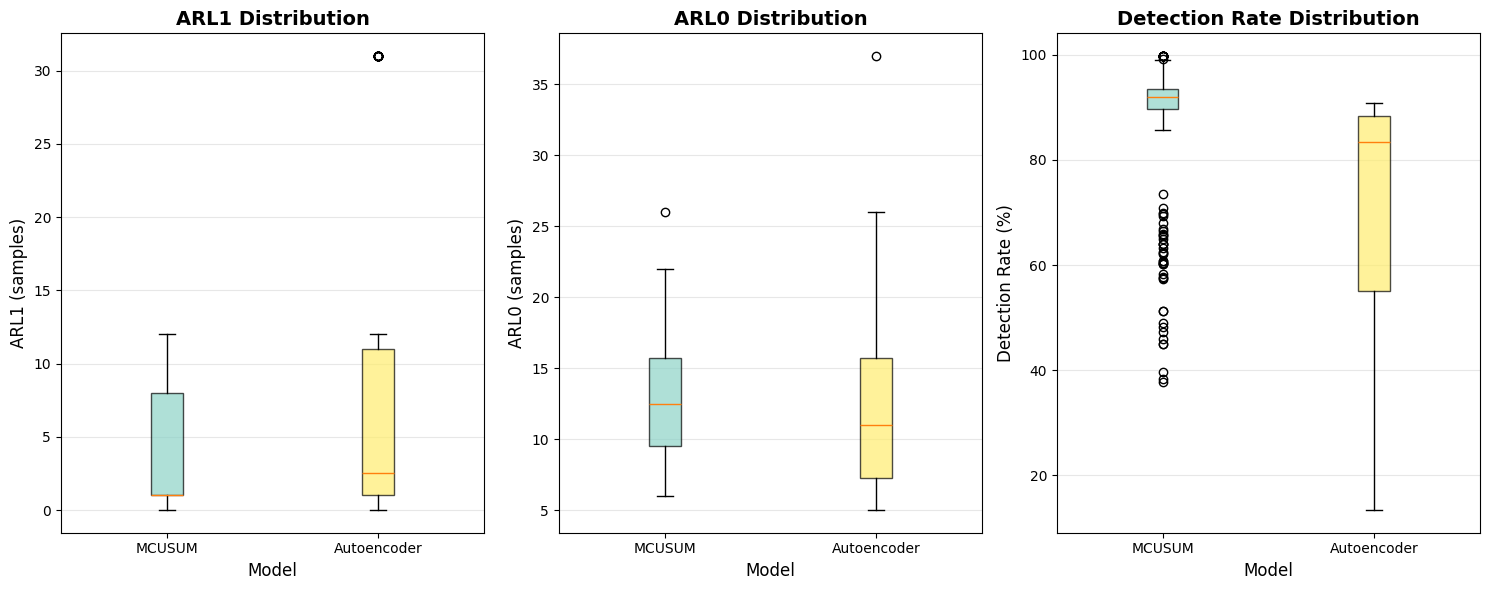

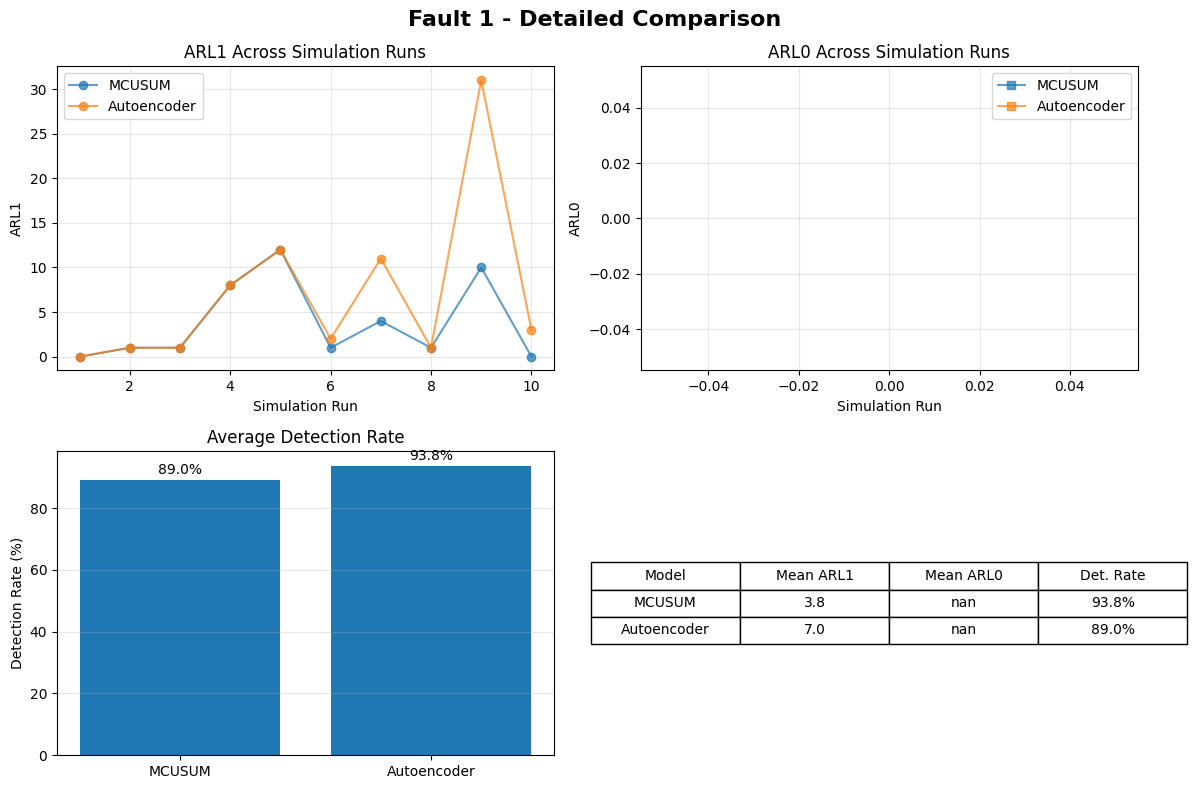

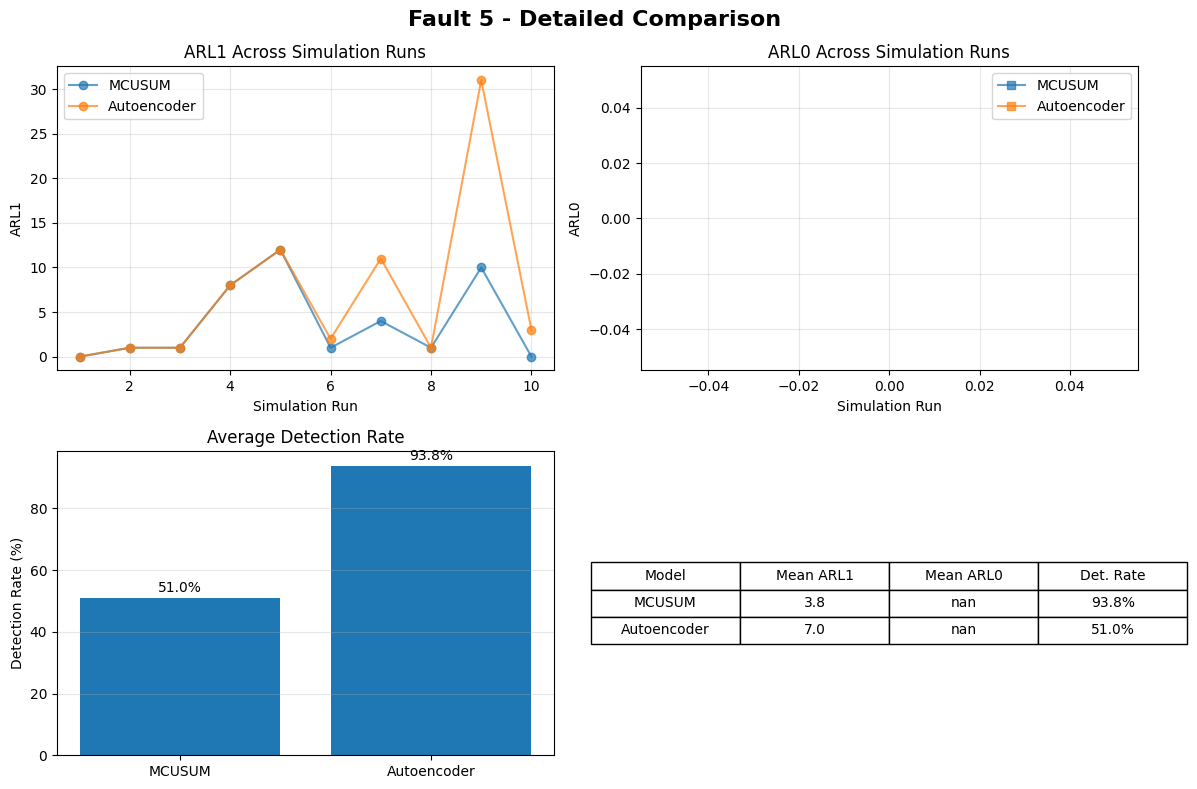

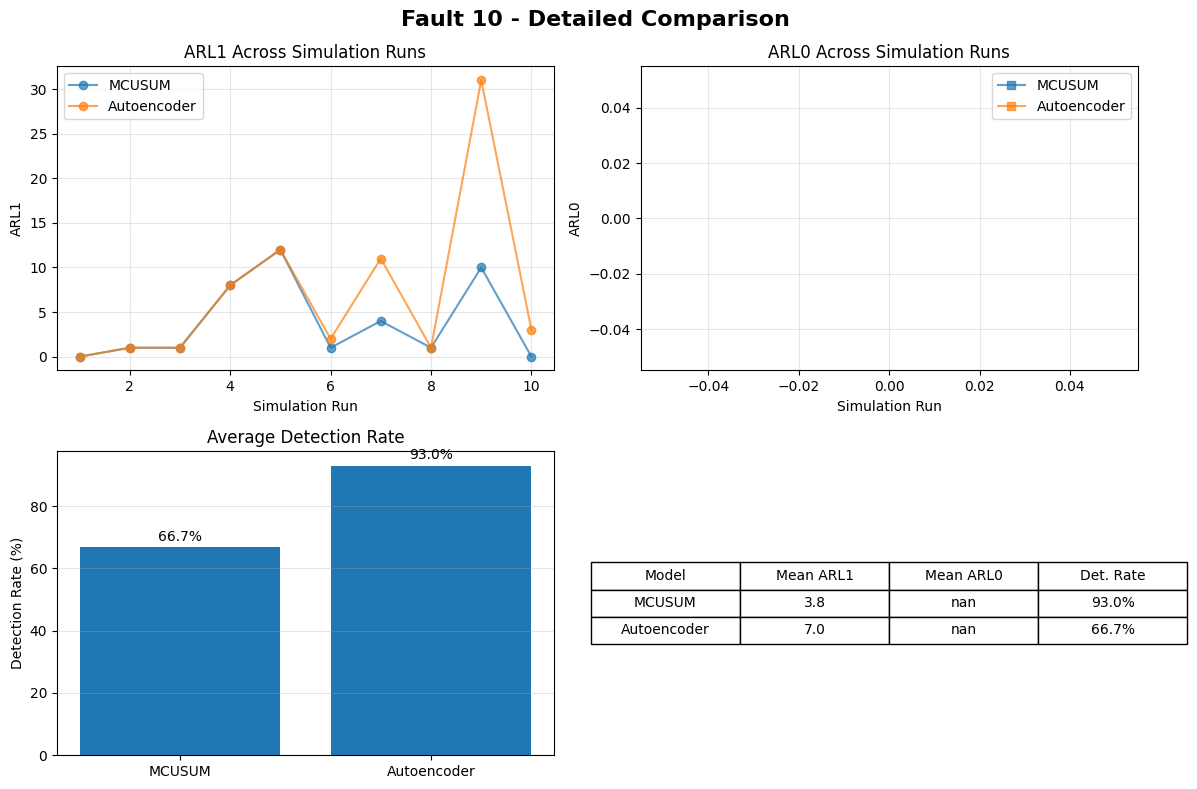

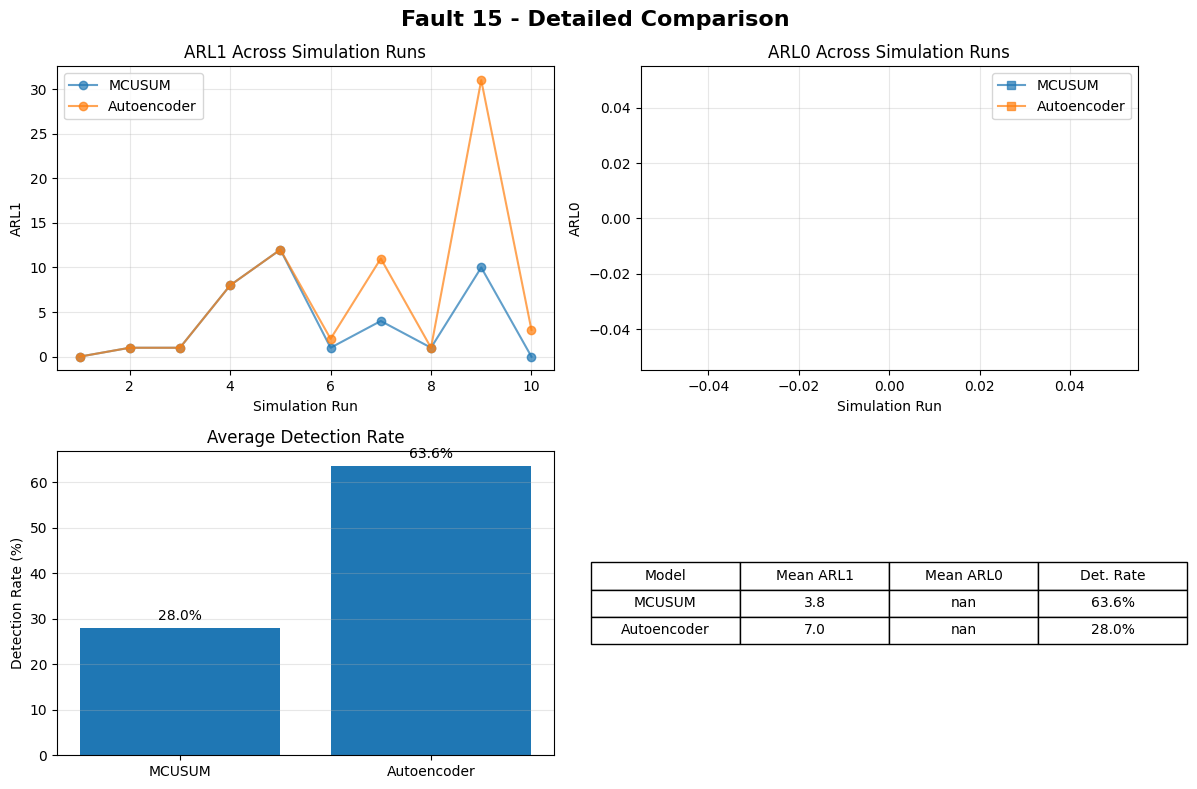

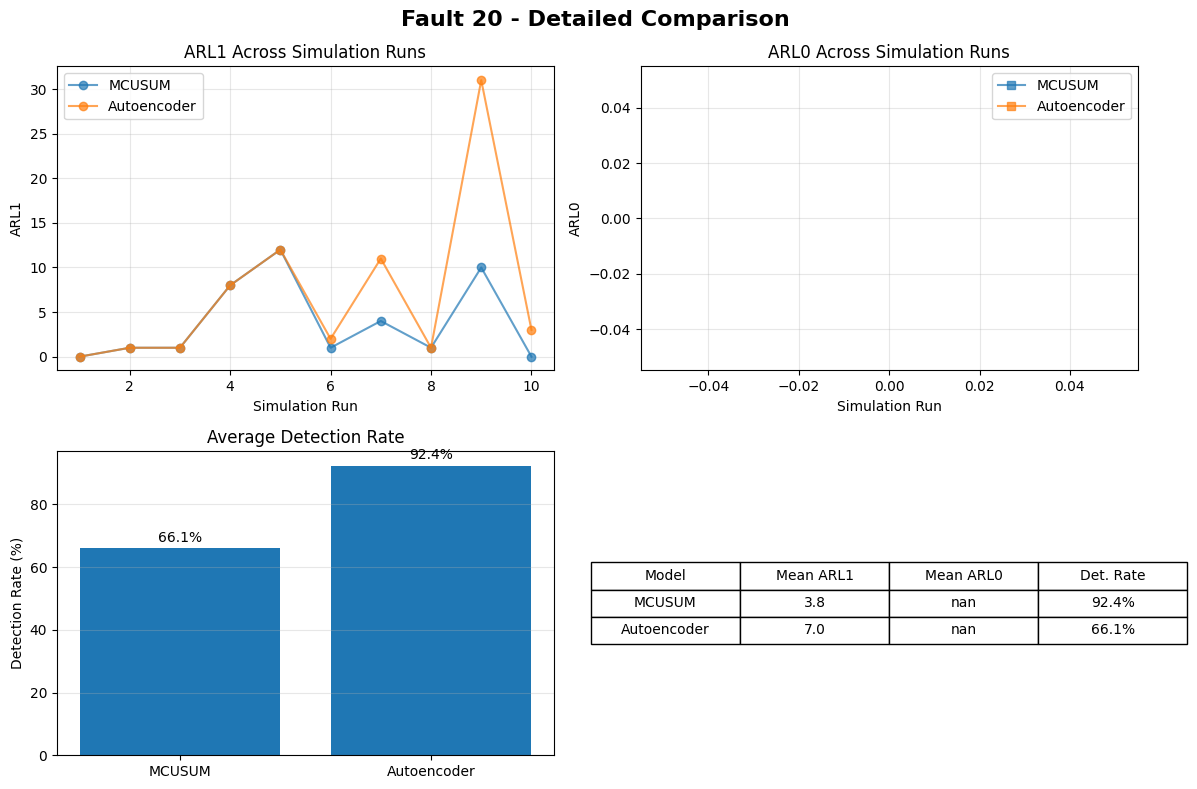

In [11]:
# Usage example:
from matplotlib import pyplot as plt


def analyze_results(df_results: pd.DataFrame, summary_df: pd.DataFrame):
    """
    Main function to run the complete analysis.
    
    Args:
        df_results: Your results DataFrame
        summary_df: Your summary DataFrame
    """
    # Initialize analyzer
    analyzer = ModelComparisonAnalyzer(df_results, summary_df)
    
    # Generate full report
    summary_stats, comparison_table = analyzer.generate_full_report()
    
    # Generate fault-specific analysis for selected faults
    for fault in [1, 5, 10, 15, 20]:  # Analyze specific faults
        if fault in analyzer.fault_numbers:
            fig = analyzer.plot_fault_specific_comparison(fault)
            plt.show()
    
    # Return analyzer for further custom analysis if needed
    return analyzer

# After your main loop, use it like this:
analyzer = analyze_results(df_results, summary_df)